# Migration Data Download

Get occurrence data from the Global Biodiversity Information Facility
(GBIF)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>In the imports cell, we’ve included some packages that you will need.
Add imports for packages that will help you:</p>
<ol type="1">
<li>Work with reproducible file paths</li>
<li>Work with tabular data</li>
</ol></div></div>

In [18]:
%store -r

In [12]:
import os
import pathlib
import pandas as pd
import geopandas as gpd
import earthpy

import time
import zipfile
from getpass import getpass
from glob import glob

import pygbif.occurrences as occ
import pygbif.species as species
import requests

For this challenge, you will need to download some data to the computer
you’re working on. We suggest using the `earthpy` library we develop to
manage your downloads, since it encapsulates many best practices as far
as:

1.  Where to store your data
2.  Dealing with archived data like .zip files
3.  Avoiding version control problems
4.  Making sure your code works cross-platform
5.  Avoiding duplicate downloads

If you’re working on one of our assignments through GitHub Classroom, it
also lets us build in some handy defaults so that you can see your data
files while you work.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Create a project folder</div></div><div class="callout-body-container callout-body"><p>The code below will help you get started with making a project
directory</p>
<ol type="1">
<li>Replace <code>'your-project-directory-name-here'</code> with a
<strong>descriptive</strong> name</li>
<li>Run the cell</li>
<li>The code should have printed out the path to your data files. Check
that your data directory exists and has data in it using the terminal or
your Finder/File Explorer.</li>
</ol></div></div>

> **File structure**
>
> These days, a lot of people find your file by searching for them or
> selecting from a `Bookmarks` or `Recents` list. Even if you don’t use
> it, your computer also keeps files in a **tree** structure of folders.
> Put another way, you can organize and find files by travelling along a
> unique **path**, e.g. `My Drive` \> `Documents` \>
> `My awesome project` \> `A project file` where each subsequent folder
> is **inside** the previous one. This is convenient because all the
> files for a project can be in the same place, and both people and
> computers can rapidly locate files they want, provided they remember
> the path.
>
> You may notice that when Python prints out a file path like this, the
> folder names are **separated** by a `/` or `\` (depending on your
> operating system). This character is called the **file separator**,
> and it tells you that the next piece of the path is **inside** the
> previous one.

/workspaces/data/gbif_download

In [2]:
# Create data directory
project = earthpy.Project(
    dirname='gbif_download')

# Display the project directory
project.project_dir

PosixPath('/workspaces/data/gbif_download')

### STEP 1: Register and log in to GBIF

You will need a [GBIF account](https://www.gbif.org/) to complete this
challenge. You can use your GitHub account to authenticate with GBIF.
Then, run the following code to enter your credentials for the rest of
your session.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-error"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>This code is <strong>interactive</strong>, meaning that it will
<strong>ask you for a response</strong>! The prompt can sometimes be
hard to see if you are using VSCode – it appears at the
<strong>top</strong> of your editor window.</p></div></div>

> **Tip**
>
> If you need to save credentials across multiple sessions, you can
> consider loading them in from a file like a `.env`…but make sure to
> add it to .gitignore so you don’t commit your credentials to your
> repository!

> **Warning**
>
> Your email address **must** match the email you used to sign up for
> GBIF!

> **Tip**
>
> If you accidentally enter your credentials wrong, you can set
> `reset=True` instead of `reset=False`.

In [3]:
####--------------------------####
#### DO NOT MODIFY THIS CODE! ####
####--------------------------####
# This code ASKS for your credentials 
# and saves it for the rest of the session.
# NEVER put your credentials into your code!!!!

# GBIF needs a username, password, and email 
# All 3 need to match the account
reset = False

# Request and store username
if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

### STEP 2: Get the taxon key from GBIF

One of the tricky parts about getting occurrence data from GBIF is that
species often have multiple names in different contexts. Luckily, GBIF
also provides a Name Backbone service that will translate scientific and
colloquial names into unique identifiers. GBIF calls these identifiers
**taxon keys**.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Put the species name, <code>{python}  scientific_name</code>, into
the correct location in the code below.</li>
<li>Examine the object you get back from the species query. What part of
it do you think might be the taxon key?</li>
<li>Extract and save the taxon key</li>
</ol></div></div>

In [ ]:
# Monarch butterfly (danaus plexippus)
backbone = species.name_backbone(name='danaus plexippus')
backbone

{'usageKey': 5133088,
 'scientificName': 'Danaus plexippus (Linnaeus, 1758)',
 'canonicalName': 'Danaus plexippus',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Arthropoda',
 'order': 'Lepidoptera',
 'family': 'Nymphalidae',
 'genus': 'Danaus',
 'species': 'Danaus plexippus',
 'kingdomKey': 1,
 'phylumKey': 54,
 'classKey': 216,
 'orderKey': 797,
 'familyKey': 7017,
 'genusKey': 5133087,
 'speciesKey': 5133088,
 'class': 'Insecta'}

In [4]:
# Sandhill crane (antigone canadensis)
backbone = species.name_backbone(name='antigone canadensis')
backbone

{'usageKey': 9036008,
 'acceptedUsageKey': 2474953,
 'scientificName': 'Antigone canadensis (Linnaeus, 1758)',
 'canonicalName': 'Antigone canadensis',
 'rank': 'SPECIES',
 'status': 'SYNONYM',
 'confidence': 98,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Gruiformes',
 'family': 'Gruidae',
 'genus': 'Grus',
 'species': 'Grus canadensis',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 1493,
 'familyKey': 9313,
 'genusKey': 2474940,
 'speciesKey': 2474953,
 'class': 'Aves'}

### STEP 3: Download data from GBIF

Downloading GBIF data is a multi-step process. However, we’ve provided
you with a chunk of code that handles the API communications and caches
the download. You’ll still need to customize your search.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Submit a request to GBIF</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Replace <code>csv_file_pattern</code> with a string that will
match <strong>any</strong> <code>.csv</code> file when used in the
<code>.rglob()</code> method. HINT: the character <code>*</code>
represents any number of any values except the file separator
(e.g. <code>/</code> on UNIX systems)</p></li>
<li><p>Add parameters to the GBIF download function,
<code>occ.download()</code> to limit your query to:</p>
<ul>
<li>observations of <span data-__quarto_custom="true"
data-__quarto_custom_type="Shortcode"
data-__quarto_custom_context="Inline"
data-__quarto_custom_id="8"></span></li>
<li>from <span data-__quarto_custom="true"
data-__quarto_custom_type="Shortcode"
data-__quarto_custom_context="Inline"
data-__quarto_custom_id="9"></span></li>
<li>with spatial coordinates.</li>
</ul></li>
<li><p>Then, run the download. <strong>This can take a few
minutes</strong>. You can check your downloads by logging on to the <a
href="https://www.gbif.org/user/download">GBIF website</a>.</p></li>
</ol></div></div>

In [ ]:
# Only download once
if not any(project.project_dir.rglob('*.csv')):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f'taxonKey = 2474953',
            'hasCoordinate = TRUE',
            f'year = 2023',
        ])
        # Take first result
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    dld_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(dld_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(dld_key)['status']
        time.sleep(5)

    # Download GBIF data
    dld_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=project.project_dir)
    dld_path = dld_info['path']

    # Unzip GBIF data
    with zipfile.ZipFile(dld_path) as dld_zip:
        dld_zip.extractall(path=project.project_dir)
        
    # Clean up the .zip file
    os.remove(dld_path)

# Find the extracted .csv file path (first result)
original_gbif_path = next(
    project.project_dir.rglob('*.csv'))
original_gbif_path

INFO:Your download key is 0026910-251009101135966


You might notice that the GBIF data filename isn’t very
**descriptive**…at this point, you may want to clean up your data
directory so that you know what the file is later on!

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace ‘your-gbif-filename’ with a <strong>descriptive</strong>
name.</li>
<li>Run the cell</li>
<li>Check your data folder. Is it organized the way you want?</li>
</ol></div></div>

In [8]:
# Give the download a descriptive name
sandhill_path = project.project_dir / '0026910-251009101135966.csv'
# Move file to descriptive path
sandhill_path

PosixPath('/workspaces/data/gbif_download/0026910-251009101135966.csv')

### STEP 4: Load the GBIF data into Python

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load GBIF data</div></div><div class="callout-body-container callout-body"><p>Just like you did when wrangling your data from the data subset,
you’ll need to load your GBIF data and convert it to a GeoDataFrame.</p></div></div>

In [9]:
!head $sandhill_path

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4773132873	4fa7b334-ce0d-4e88-aaae-2e0c138d049e	URN:catalog:CLO:EBIRD:OBS1599068068	Animalia	Chordata	Aves	Gruiformes	Gruidae	Grus	Grus canadensis		SPECIES	Antigone canadensis (Linnaeus, 1758)	Antigone canadensis		US	6345 Spurrier Rd, Big Clifty US-KY 37.48905, -86.07725	Kentucky	PRESENT	15	e2e717bf-551a-4917-bdc9-4fa0f342c530	37.489044	-86.077255							2023-01-

In [ ]:
# Load the GBIF data
sandhill_df = pd.read_csv(
    sandhill_path,
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID', 'decimalLatitude', 'decimalLongitude', 'month']
)
sandhill_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
4773132873,37.489044,-86.077255,1
4698503071,41.955400,-82.514000,5
4744751186,42.579630,-82.803270,5
4708960325,28.160494,-81.858650,3
4790233265,27.006525,-81.883934,3


In [13]:
# Convert to GeoDataFrame
sandhill_gdf = (
    gpd.GeoDataFrame(
        sandhill_df,
        geometry=gpd.points_from_xy(
            sandhill_df.decimalLongitude,
            sandhill_df.decimalLatitude),
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

sandhill_gdf

,month,geometry
gbifID,,
4773132873,1,POINT (-86.07726 37.48904)
4698503071,5,POINT (-82.514 41.9554)
4744751186,5,POINT (-82.80327 42.57963)
4708960325,3,POINT (-81.85865 28.16049)
4790233265,3,POINT (-81.88393 27.00652)
...,...,...
4103738021,3,POINT (-98.895 40.6437)
4135517029,5,POINT (-84.2403 42.3291)
4953718225,3,POINT (-109.051 32.084)


In [14]:
# Check results
sandhill_gdf.total_bounds

array([-173.33992 ,   11.113962,  175.9172  ,   74.0697  ])

<Axes: >

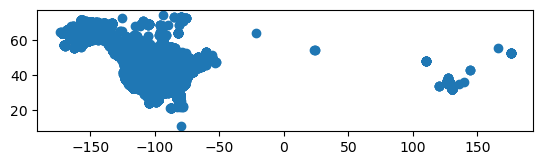

In [16]:
sandhill_gdf.plot()

In [20]:
ecoregions_plot_gdf

,SHAPE_AREA,geometry,ECO_NAME
ecoregion,,,
0,0.038948,"POLYGON ((17090104.083 -10646152.188, 17100906...",Adelie Land tundra
1,0.170599,"MULTIPOLYGON (((16461836.873 -254248.259, 1644...",Admiralty Islands lowland rain forests
2,13.844952,"MULTIPOLYGON (((3391149.749 4336064.109, 33985...",Aegean and Western Turkey sclerophyllous and m...
3,1.355536,"MULTIPOLYGON (((7369001.698 4093509.259, 73168...",Afghan Mountains semi-desert
4,8.196573,"MULTIPOLYGON (((-17912546.29 8050475.591, -179...",Ahklun and Kilbuck Upland Tundra
...,...,...,...
842,9.422097,"MULTIPOLYGON (((14113374.546 501721.962, 14128...",Sulawesi lowland rain forests
843,5.010930,"MULTIPOLYGON (((4275410.576 -149750.128, 42781...",East African montane forests
844,0.890325,"MULTIPOLYGON (((4302962.15 -537675.265, 431112...",Eastern Arc forests


In [ ]:
# Identify ecoregion for each observation
sandhill_ecoregion_gdf = (
    ecoregions_plot_gdf
    .to_crs(sandhill_gdf.crs)
    .sjoin(
        sandhill_gdf,
        how='inner',
        predicate='contains')
    # Select the required columns
    [['month', 'ECO_NAME']]
    )
sandhill_ecoregion_gdf

,month,ECO_NAME
ecoregion,,
4,8,Ahklun and Kilbuck Upland Tundra
4,5,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
...,...,...
833,9,Northern Rockies conifer forests
833,4,Northern Rockies conifer forests
833,5,Northern Rockies conifer forests


In [23]:
# Count observations in each ecoregion by month
sandhill_occurrence = (
    sandhill_ecoregion_gdf
    # For each ecoregion, for each month
    .groupby(['ecoregion', 'month'])
    # And count the number of occurrences
    .agg(occurrences=('ECO_NAME', 'count'))
)
sandhill_occurrence

occurrences
ecoregion month             
4         5                2
          6                1
          7                5
          8                1
9         5                3
...                      ...
833       7              169
          8              176
          9              134
          10              95
          11              25

[851 rows x 1 columns]

In [24]:
# Get rid of rare observations (possible misidentification?)
sandhill_occurrence = sandhill_occurrence[sandhill_occurrence.occurrences>1]
sandhill_occurrence

occurrences
ecoregion month             
4         5                2
          7                5
9         5                3
          6                2
          8                8
...                      ...
833       7              169
          8              176
          9              134
          10              95
          11              25

[778 rows x 1 columns]

In [25]:
# Take the mean by ecoregion
shc_mean_occurrences_by_ecoregion = (
    sandhill_occurrence
    .groupby(['ecoregion'])
    .mean()
)
shc_mean_occurrences_by_ecoregion

,occurrences
ecoregion,
4,3.500000
9,6.500000
10,2.000000
12,27.166667
15,24.000000
...,...
820,6.333333
821,61.571429
822,4.000000


In [26]:
# Take the mean by month
shc_mean_occurrences_by_month = (
    sandhill_occurrence
    .groupby(['month'])
    .mean()
)

shc_mean_occurrences_by_month

,occurrences
month,
1,430.580000
2,398.942308
3,501.774194
4,616.680556
5,636.425000
6,295.633803
7,224.623188
8,262.318841
9,282.041667


In [27]:
# Normalize the observations by the monthly mean throughout the year
sandhill_occurrence['norm_occurrences'] = (
    sandhill_occurrence
    / shc_mean_occurrences_by_ecoregion 
    / shc_mean_occurrences_by_month
)
sandhill_occurrence

/tmp/ipykernel_25604/479735125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sandhill_occurrence['norm_occurrences'] = (


occurrences  norm_occurrences
ecoregion month                               
4         5                2          0.000898
          7                5          0.006360
9         5                3          0.000725
          6                2          0.001041
          8                8          0.004692
...                      ...               ...
833       7              169          0.004548
          8              176          0.004055
          9              134          0.002872
          10              95          0.001834
          11              25          0.000446

[778 rows x 2 columns]

In [40]:
# Import libraries for interactive mapping
from bokeh.models import HoverTool
import holoviews as hv
import hvplot.pandas

import calendar
import panel as pn
import cartopy.crs as ccrs

In [34]:

# Join the SHC occurrences with the ecoregions map
shc_occurrence_gdf = ecoregions_plot_gdf.join(sandhill_occurrence)
shc_occurrence_gdf

# Get the plot bounds so they don't change with slider
xmin, ymin, xmax, ymax = shc_occurrence_gdf.total_bounds

# Define slider widget
slider = pn.widgets.DiscreteSlider(
    name='month',
    options={calendar.month_name[i]: i for i in range(1,13)}
)

# Create hover tool to show numbers as decimals
hover = HoverTool(tooltips=[("norm_occurrences", "@norm_occurrences{'.0f'}")])

In [41]:
# Create interactive map of SHC migration 2023
sandhill_migration_plot = (
    shc_occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='EsriWorldLightGrayBase',
        title='Sandhill Crane Migration 2023',
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        widgets={'month': slider},
        widget_location='bottom',
        colormap='reds',
        colorbar=True,
        yformatter='%.0f',
        tools=[hover]

    )
)

# Save the plot
sandhill_migration_plot.save('sandhill-migration.html', embed=True)

# Show the plot
sandhill_migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'b8bf124b-a773-4824-b636-25e841d855ae': {'version…

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [15]:
%store sandhill_gdf

Stored 'sandhill_gdf' (GeoDataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!